In [1]:
from pydantic import  Field
from typing import TypedDict, Literal, Optional
from langgraph.graph import StateGraph, START
from langchain_openai import AzureChatOpenAI
import os 
from typing import Annotated
from typing_extensions import TypedDict
import os
import warnings
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)
from chatbot.agents.chat_pdf import * 
from chatbot.agents.sql_agent import SQL_tool
from chatbot.agents.expert import AI_Expert
from chatbot.agents.Tavily_search_agent import Search_agent
warnings.filterwarnings('ignore')
import re
from langchain_google_genai import GoogleGenerativeAIEmbeddings

import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver
import sqlite3  
from langchain_chroma import Chroma
import chromadb
from langchain_core.messages import AIMessage, HumanMessage,ToolMessage,SystemMessage
from langgraph.graph import END, START, StateGraph
import shutil


In [2]:
OPENAI_API_KEY = os.getenv("AZURE_OPEN_AI_KEY")
AZURE_ENDPOINT = os.getenv("AZURE_ENDPOINT")
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")



In [3]:
agents = ['amazon_policy','sql_agent','search_engine',"sale_expert",'recall_memory']

In [4]:

system_prompt = (
   """You are a supervisor responsible for managing a conversation between the following workers:'amazon_policy','sql_agent','search_engine',"sale_expert",'recall_memory'. Your task is to decide which worker should act next based on the user request and the current progress of the task.
Each worker has a specific role:
amazon_policy → Handles questions related to Amazon Policy for sellers and shoppers.
sale_expert → Handles questions related to Marketing, Sales and E-commerce in general, when user askes for advices and stratergies to benefit the store.
sql_agent → Retrieves information about customers, orders and revenue details.
search_engine → Search real-time information on Amazon, news, market and trends in real world.
If user ask about conversation chat history, use recall_memory for context to answer, always check the closest history 
"""
)


In [5]:
class Router(TypedDict):
    next: Literal[*agents] = Field(
        None, description="The next agents in the routing process"
    )

class AgentState(TypedDict):
    input: str
    decision: Optional[str]  
    output: Optional[ToolMessage]
    reflection_feedback: Optional[str]
    needs_refinement: Optional[bool]


In [6]:
def Semantic_memory():
    embedding = GoogleGenerativeAIEmbeddings(
        model="models/embedding-001",
        api_key=GOOGLE_API_KEY,
        task_type="retrieval_document"
    )
    
    semantic_db = Chroma(
    client=chromadb.PersistentClient(path=r"C:\Users\Admin\Desktop\Data projects\python\Decision-making-system\BACKEND\chatbot\database\orchestrator_memory"),
    collection_name='langraph_memory',
    embedding_function=embedding,
)
    return semantic_db

In [7]:
def initialize_checkpointer(db_path):
    """Ensures the checkpointer database is not corrupted by recreating it if necessary."""
    try:
        conn = sqlite3.connect(db_path, check_same_thread=False)
        return SqliteSaver(conn)
    except sqlite3.DatabaseError:
        shutil.rmtree(db_path, ignore_errors=True)  
        conn = sqlite3.connect(db_path, check_same_thread=False)
        return SqliteSaver(conn)

In [8]:
llm = AzureChatOpenAI(openai_api_key=OPENAI_API_KEY,
                        openai_api_version="2024-08-01-preview",
                        model ="gpt-4o-mini",
                        openai_api_base=AZURE_ENDPOINT, temperature=0)

In [9]:

def search_engine(state: AgentState):
    """Handles IT-related searches using Tavily API."""
    try:
        query = state["input"]  
        result = Search_agent(query)  

        return  {"output": result}
    except Exception as e:
        return {"output": AIMessage(content=f"Error in  search: {str(e)}")}

def amazon_policy(state: AgentState):
    try:
        query = state["input"]  
        result = RAG_QA(query)  
        return {"output": result}
    except Exception as e:
        return {"output": f"Error retrieving policy information: {str(e)}"}
def sale_expert(state: AgentState):
    try:
        query = state["input"]  
        result = AI_Expert(query)  
        return {"output": result}
    except Exception as e:
        return {"output": f"Error retrieving expert information: {str(e)}"}
    
def sql_agent(state: AgentState):
    """Handles SQL-based customer ticket searches."""
    try:
        query = state["input"]  
        result = SQL_tool(query)

        return {"output": result}
    except Exception as e:
        return {"output": AIMessage(content=f"Error accessing database: {str(e)}")}



In [10]:
def recall_memory(state: AgentState):
    """Handles memory recall for previous interactions."""
    memory_prompt = """ 
  You are a Supervisor handling {agents}. You also have to handle questions about previous interactions, chat history, and follow-up questions.
    If the user asks about previous conversations, retrieve relevant past interactions and provide an answer.
    If the user asks a follow-up question, recall the past response and use it as context before deciding on the next tool to use.
    """
    memory = Semantic_memory()
    past_interactions = memory.search(state["input"], search_type='similarity',k=1)

    history_context = "\n".join([
        f"{item.metadata['query']} → {item.metadata['response']}" for item in past_interactions
    ])

    if history_context:
        prompt_with_memory = f"{memory_prompt}\n\nPrevious Conversations:\n{history_context}\n\nUser: {state['input']}"
    else:
        prompt_with_memory = f"{memory_prompt}\n\nUser: {state['input']}"

    recall = llm.invoke([
        SystemMessage(content=prompt_with_memory),
        HumanMessage(content=state["input"]),
    ])

    return {"output": AIMessage(content=recall.content)}

## **Supervisor -> Agent -> -> Tools -> answer**

In [11]:
def supervisor_node(state: AgentState):
    decision = llm.with_structured_output(Router).invoke(
        [
            SystemMessage(content=system_prompt),
            HumanMessage(content=state["input"]),
        ]
    )

    print("Decision from LLM:", decision)  # <-- This line prints the decision

    if not isinstance(decision, dict) or "next" not in decision or decision["next"] is None:
        return {"decision": "recall_memory"}  

    return {"decision": decision["next"]}


In [12]:
def route_decision(state: AgentState):
    decision = state.get("decision", None)
    
    if decision == "amazon_policy":
        return "amazon_policy"
    elif decision == "sale_expert":
        return "sale_expert"
    elif decision == "sql_agent":
        return "sql_agent"
    elif decision == "search_engine":
        return "search_engine"
    elif decision == "recall_memory":
        return "recall_memory"
    else:
        print(f"Unexpected decision value: {decision}")
        return "recall_memory"

In [13]:
def reflection_node(state: AgentState):
    """
    Analyze the output from previous node and determine if refinement is needed.
    Provides specific feedback if improvement is required.
    """
    output = state.get("output", None)
    if isinstance(output, str):
        output_content = output
    elif hasattr(output, "content"):
        output_content = output.content
    else:
        output_content = str(output) if output else ""
    user_input = state.get("input", "")
    
    reflection_prompt = f"""
    Analyze the following output to determine if it correctly and effectively answers the user query:
    
    USER QUERY: "{user_input}"
    
    OUTPUT: {output_content}
    
    First, decide if this output needs improvement by evaluating:
    1. It should not contain any complicated jargon or terms that are not directly related to the user's query.
    2. Does it directly answer the user's query?
    3. If it contains SQL queries, are they optimized and correct?
    4. Is it clear, concise and not too complicated for the user?
    
    INSTRUCTIONS:
    - First, determine YES or NO if refinement is needed
    - If YES, provide specific, actionable feedback on what to improve
    - If SQL queries exist, check for proper indexing, join optimization, and query structure
    - Focus on completeness, clarity, and relevance to the original query
    
    Format your response as:
    NEEDS_REFINEMENT: [YES or NO]
    FEEDBACK: [Your detailed feedback if refinement is needed, otherwise "No refinement needed"]
    """
    
    reflection_response = llm.invoke(
        [
            SystemMessage(content="You are a critical AI output reviewer. Your job is to determine if content needs improvement and provide specific, actionable feedback."),
            HumanMessage(content=reflection_prompt),
        ]
    )
    
    if isinstance(reflection_response, str):
        response_text = reflection_response
    else:
        response_text = reflection_response.content
    
    needs_refinement = False
    feedback = "No refinement needed"
    
    if "NEEDS_REFINEMENT: YES" in response_text.upper():
        needs_refinement = True
        
        # Extract feedback section
        feedback_pattern = r"FEEDBACK:\s*(.*?)(?=$|NEEDS_REFINEMENT:)"
        feedback_match = re.search(feedback_pattern, response_text, re.DOTALL | re.IGNORECASE)
        if feedback_match:
            feedback = feedback_match.group(1).strip()
        else:
            parts = response_text.split("FEEDBACK:", 1)
            if len(parts) > 1:
                feedback = parts[1].strip()
    
    print(f"Reflection analysis - Needs refinement: {needs_refinement}")
    print(f"Feedback: {feedback}")
    
    return {
        "reflection_feedback": feedback,
        "needs_refinement": needs_refinement
    }

In [14]:
def refined_node(state: AgentState):
    """
    Refine the output based on user input and reflection feedback
    """
    output = state.get("output", None)
    feedback = state.get("reflection_feedback", "")
    user_input = state.get("input", "")
    needs_refinement = state.get("needs_refinement", False)
    
    if not needs_refinement or not output:
        return {"output": output}
    
    original_response = (
        output.content if hasattr(output, "content") else (output if isinstance(output, str) else "")
    )

    refinement_prompt = f"""
    ORIGINAL USER QUERY: {user_input}

    ORIGINAL RESPONSE: {original_response}

    IMPROVEMENT FEEDBACK: {feedback}

    INSTRUCTIONS:
    You must refine the original response strictly based on the feedback above. Do not add any new facts, details, or assumptions that are not present in the original response or the feedback.

    1. Only rewrite the response using the original content and the feedback provided.
    2. Do NOT introduce new content or change the meaning of the original answer.
    3. Ensure the response is improved for clarity, accuracy, and completeness only within the scope of the original answer.
    4. Do NOT add explanations about the refinement process.
    5. If the feedback involves SQL optimization, only modify the query logic without adding new unrelated queries or logic.
    6. Provide only the final refined response.
    """
    
    refined_response = llm.invoke(
        [
            SystemMessage(content="You are an expert at refining AI outputs based on feedback. Your job is to create a clear, concise and accurate response that addresses all the issues identified in the feedback."),
            HumanMessage(content=refinement_prompt),
        ]
    )
    
    refined_output = AIMessage(content=refined_response.content if hasattr(refined_response, "content") else str(refined_response))
    
    return {"output": refined_output}


In [15]:
def should_refine(state: AgentState):
    """
    Determine if the output needs reflection based on the source node.
    Only amazon_policy, sale_expert, and sql_agent should go through reflection.
    """
    decision = state.get("decision", None)
    
    # Only these specific nodes should go through reflection
    if decision in ["amazon_policy", "sale_expert", "sql_agent"]:
        return "check_reflection"
    else:
        # All other nodes skip reflection entirely
        return "skip_refinement"

In [16]:
def needs_refinement_check(state: AgentState):
    """
    Based on the reflection node's determination, either proceed to refinement
    or skip directly to END
    """
    if state.get("needs_refinement", False):
        return "refine"  
    else:
        return "no_refine"  

In [17]:
# Build the graph
builder = StateGraph(AgentState)
builder.add_node("supervisor_node", supervisor_node)
builder.add_node("amazon_policy", amazon_policy)
builder.add_node("sale_expert", sale_expert)
builder.add_node("sql_agent", sql_agent)
builder.add_node("search_engine", search_engine)
builder.add_node("recall_memory", recall_memory)
builder.add_node("reflection_node", reflection_node)
builder.add_node("refined_node", refined_node)

builder.add_edge(START, "supervisor_node")
builder.add_conditional_edges(
    "supervisor_node",
    route_decision,
    {
        "amazon_policy": "amazon_policy",
        "sale_expert": "sale_expert",
        "sql_agent": "sql_agent",
        "search_engine": "search_engine",
        "recall_memory": "recall_memory",
    },
)
builder.add_conditional_edges(
    "amazon_policy",
    should_refine,
    {
        "check_reflection": "reflection_node",
        "skip_refinement": END,
    },
)
builder.add_conditional_edges(
    "sale_expert",
    should_refine,
    {
        "check_reflection": "reflection_node",
        "skip_refinement": END,
    },
)

builder.add_conditional_edges(
    "sql_agent",
    should_refine,
    {
        "check_reflection": "reflection_node",
        "skip_refinement": END,
    },
)
builder.add_edge("search_engine", END)
builder.add_edge("recall_memory", END)

builder.add_conditional_edges(
    "reflection_node",
    needs_refinement_check,
    {
        "refine": "refined_node",  
        "no_refine": END,          
    },
)
builder.add_edge("refined_node", END)
db_path=r'C:\Users\Admin\Desktop\Data projects\python\Decision-making-system\BACKEND\chatbot\database\chat_history.db'
memory = initialize_checkpointer(db_path)
graph = builder.compile(checkpointer=memory, store=Semantic_memory())  

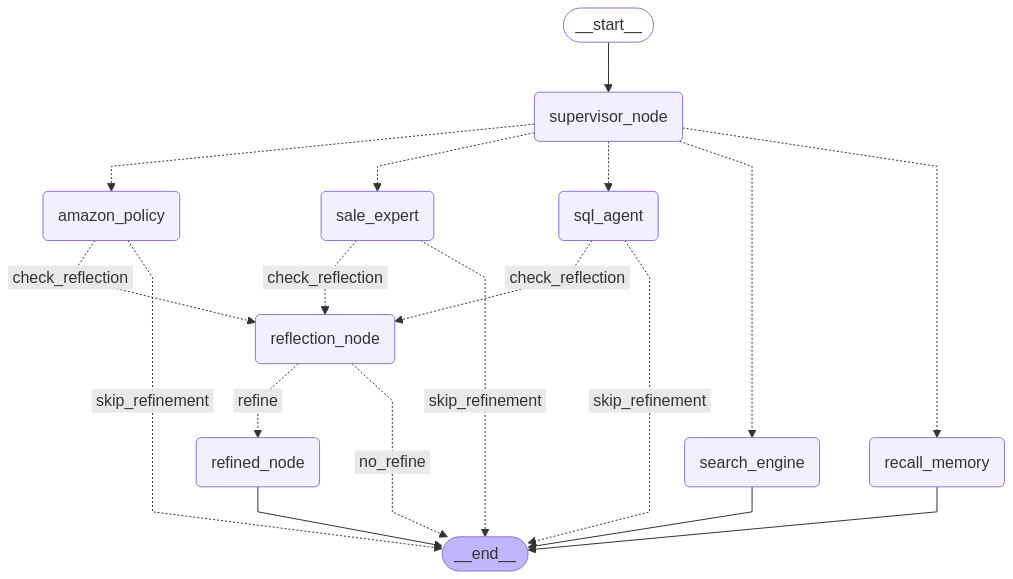

In [18]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
config = {"configurable": { "thread_id": "eeeee"} }

In [20]:
user_input = "hello"
events = graph.stream(
    {"input": user_input},
    config=config,
    stream_mode="values",


)
chat_history = []
for event in events:
    chat_history.append(event)

response = event["output"].content if isinstance(event["output"], AIMessage) else event["output"]

memory = Semantic_memory()  
doc_id = f"msg_{id}_{len(chat_history)}"
memory.add_texts(
    ids=[doc_id],
    texts=[f"Query: {user_input}\nResponse: {response}"],
    metadatas=[{"query": user_input, "response": response}]
)

print(response)

Decision from LLM: {'next': 'recall_memory'}
Hello! How can I assist you today?
